## CDMs - Análisis por misión

En esta notebook hacemos una primera revisión de los datos de entrenamiento

### Carga de librerías y setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

### Carga de datos crudos

In [3]:
data = pd.read_csv('./train_data/train_data.csv')

Definimos un campo que sea un ID de cada CMD dentro de un mismo evento

In [4]:
data = data.sort_values(["event_id", "time_to_tca"], ascending=[True, False])

In [5]:
data["cmd_id"] = data.groupby("event_id")["time_to_tca"].rank(ascending=False)

C:\Users\pablo\AppData\Local\Temp\ipykernel_27452\279891090.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["cmd_id"] = data.groupby("event_id")["time_to_tca"].rank(ascending=False)


### Análisis

Evaluamos si las misiones involucradas son todas LEO

In [6]:
def classify_mission(row):
    if row["t_h_apo"] < 2000 and row["t_h_per"] < 2000:
        return "LEO"
    elif row["t_h_apo"] >= 35786 and row["t_h_per"] >= 35786:
        return "GEO"
    elif (row["t_h_apo"] >= 2000 and row["t_h_apo"] < 35786) or (row["t_h_per"] >= 2000 and row["t_h_per"] < 35786):
        return "MEO"
    else:
        return "HEO"

data["type_of_mission"] = data.apply(classify_mission, axis=1)

C:\Users\pablo\AppData\Local\Temp\ipykernel_27452\3027842670.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["type_of_mission"] = data.apply(classify_mission, axis=1)


In [7]:
data["type_of_mission"].value_counts()

type_of_mission
LEO    162634
Name: count, dtype: int64

In [8]:
data = data.drop(columns=["type_of_mission"])

Se verifica que todas las misiones del dataset son LEO. Eso implica que:

- No hay mezcla de regímenes dinámicos radicalmente distintos (GEO, MEO, HEO).
- La física orbital subyacente es comparable.
- Las velocidades relativas son del orden LEO (~7–14 km/s).
- La incertidumbre along-track domina en todos los casos.

Si todas son LEO, las diferencias en CDMs por evento no pueden explicarse por:

- Cambio de régimen orbital (LEO vs GEO)
- Diferencias dramáticas en velocidad orbital
- Diferencias estructurales extremas en dinámica

Por lo tanto, las diferencias entre misiones probablemente se deban a:

- Diferencias de altitud dentro de LEO (500 km vs 900 km)
- Diferencias en inclinación (SSO vs no polar)
- Diferente densidad de tráfico orbital
- Diferente política de seguimiento
- Diferente criticidad del activo

Aunque todas sean LEO, no todos los LEO son iguales.

Por ejemplo:

- Una órbita ~600 km polar (SSO) atraviesa regiones muy congestionadas.
- Una órbita ~400 km puede tener mayor arrastre atmosférico.
- Una órbita ~1000 km puede tener distinta población de fragmentos.

Entonces el entorno de conjunciones puede variar mucho incluso dentro de LEO.

Revisamos las distribuciones de altitud en el apogeo y periogeo, y la inclinación de la órbita. Calculamos las cantidades medias por misión

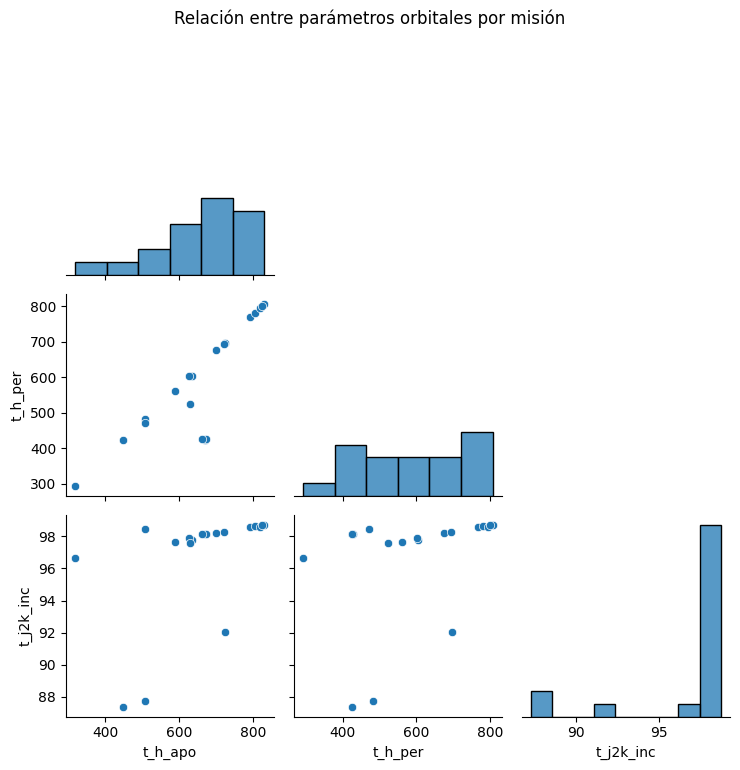

In [9]:
sns.pairplot(
    data=data.groupby("mission_id")[["t_h_apo", "t_h_per", "t_j2k_inc"]].mean(),
    corner=True
)
plt.suptitle("Relación entre parámetros orbitales por misión", y=1.02)
plt.tight_layout()
plt.show()


1. Análisis de altitud
   
   Se detectan "pisos" orbitales. En el plano t_h_apo vs t_h_per se observa:
   - Misiones alrededor de ~350–450 km
   - Otro grupo en ~500–650 km
   - Otro grupo cerca de ~750–820 km
   
   No es una nube continua. Hay clusters de altitud bien definidos. Eso significa:
   
   - Las misiones están operando en distintas capas de LEO.
   Eso es crucial porque la densidad de tráfico no es uniforme con la altitud.

2. Análisis de inclinación

   Fuerte concentración cerca de 97-99°. El histograma muestra:
   - La mayoría entre ~97-99°
   - Algunos outliers en ~87-92°
  
   Esto es muy característico de órbitas polares/helisincrónicas (SSO). Es decir, muchas de estas misiones probablemente son SSO, las cuales se encuentran entre las órbitas más congestionadas de LEO.

   Esto explica varios puntos:

   - Misiones en ~800 km SSO → altísima densidad de tráfico.
   - Misiones en ~400 km → menor permanencia de debris (más drag).
   - Misiones en ~600 km → zona históricamente congestionada.
   
   Por lo tanto:
   Las diferencias en CDMs por evento pueden estar correlacionadas con altitud. No necesariamente con política.

Ahora tenemos:

- Todas LEO
- Pero en distintas capas de LEO
- Muchas en SSO

Eso significa que el entorno de conjunciones no es homogéneo. Una hipótesis razonable es que misiones en mayor altitud promedio → mayor cantidad de CDMs por evento, porque:

- Más objetos en esa región
- Mayor vida orbital de fragmentos
- Más persistencia del riesgo

In [10]:
altitude_and_events_per_mission = data.groupby("mission_id").agg({
    "t_h_apo": "mean",
    "event_id": "nunique"
}).reset_index()

In [11]:
cmds_per_mission = data.groupby("mission_id").agg({
    "cmd_id": "size"
}).reset_index()

In [12]:
df = altitude_and_events_per_mission.merge(cmds_per_mission, on="mission_id")
df["cmds_per_evento"] = df["cmd_id"] / df["event_id"]

In [13]:
df.drop(columns=["mission_id"]).corr()

,t_h_apo,event_id,cmd_id,cmds_per_evento
t_h_apo,1.000000,0.002499,0.115495,0.666477
event_id,0.002499,1.000000,0.972813,0.357733
cmd_id,0.115495,0.972813,1.000000,0.488164
cmds_per_evento,0.666477,0.357733,0.488164,1.000000


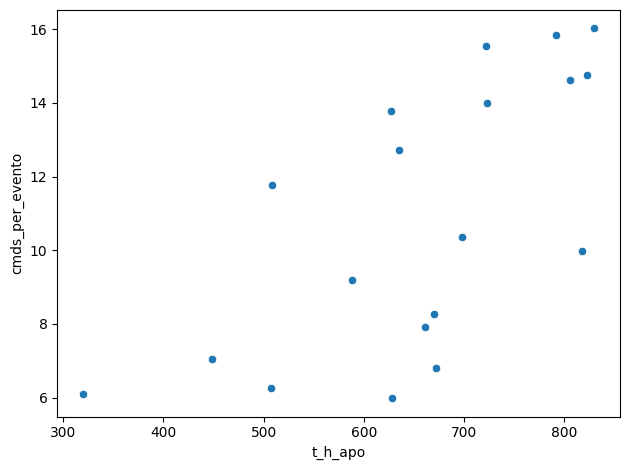

In [14]:
sns.scatterplot(
    data=df,
    x="t_h_apo",
    y="cmds_per_evento",
)
plt.tight_layout()
plt.show()

Relación entre altitud orbital y cantidad de CDMs por evento

Se analizó la relación entre la altitud media de cada misión (t_h_apo) y la intensidad de seguimiento medida como cantidad promedio de CDMs por evento.

1. Resultado principal
   
   Se obtuvo para la correlación entre la altura promedio en el apoastro y la cantidad de CMDs igual a 0.666. Esto indica una relación positiva fuerte entre altitud y número promedio de CDMs por evento. No se trata de una correlación marginal, sino de una señal estructural clara.

2. Interpretación física
   
   Dentro del régimen LEO, la altitud modula fuertemente el entorno dinámico:
   
   - LEO baja (~300–400 km)
     - Mayor arrastre atmosférico.
     - Vida orbital de fragmentos más corta.
     - Menor persistencia de objetos en esa región
     
     Consecuencia:
     - Eventos que tienden a resolverse más rápidamente.
     - Menor cantidad de CDMs por evento.
     - Menor persistencia del seguimiento.
   - LEO media-alta (~600-850 km)
     - Arrastre atmosférico reducido.
     - Fragmentos con vida orbital prolongada (años o décadas).
     - Alta concentración de órbitas SSO.
     - Mayor densidad de tráfico espacial.

     Consecuencia:
     - Eventos más persistentes.
     - Mayor seguimiento operacional.
     - Mayor número de CDMs por evento.

3. Diferenciación respecto al volumen de eventos
   
   Se observó además que:
   - La correlación entre número total de eventos y número total de CDMs es muy alta (~0.97), lo cual es esperable.
   - Sin embargo, la correlación entre altitud y CDMs promedio por evento (~0.666) es significativamente mayor que la correlación entre cantidad de eventos y CDMs promedio (~0.36).

   Esto sugiere que la intensidad de seguimiento está más asociada al entorno orbital que simplemente al volumen de eventos.

   - Las diferencias entre misiones no son puramente operacionales o políticas.
   - El entorno físico orbital (altitud dentro de LEO) influye directamente en la dinámica temporal del evento.
   - La persistencia del riesgo y la frecuencia de actualización parecen estar moduladas por la capa orbital.
   
   Por lo tanto, el dataset no representa un LEO homogéneo, sino un LEO multicapa con entornos dinámicos diferenciados.

**Conclusión**

La altitud promedio de la misión es un factor estructural que explica en parte la intensidad de seguimiento (CDMs por evento).

Esto refuerza que el proceso generador de datos combina:

- Física orbital (densidad de tráfico, persistencia de debris).
- Dinámica temporal del riesgo.
- Decisiones operacionales de seguimiento.

En consecuencia, cualquier análisis del risk debe considerar la segmentación por capa orbital dentro de LEO para evitar mezclar regímenes dinámicos distintos.

In [25]:
data.groupby("mission_id")["t_h_apo"].std()/data.groupby("mission_id")["t_h_apo"].mean()

mission_id
1     0.011117
2     0.009840
3     0.009394
4     0.008872
5     0.014948
6     0.023303
7     0.016502
9     0.012664
10    0.018500
13    0.008308
14    0.015005
15    0.011058
16    0.009993
18    0.009945
19    0.010875
20    0.015965
22    0.016494
23    0.016692
24    0.019605
Name: t_h_apo, dtype: float64

In [45]:
avg_t_h_apo = data.groupby("mission_id")["t_h_apo"].mean().reset_index()

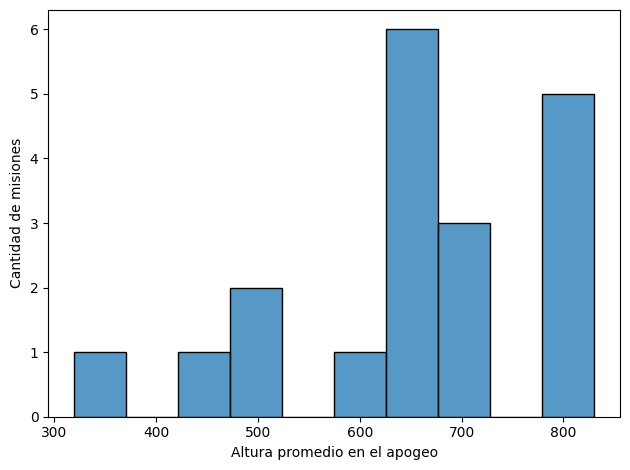

In [46]:
sns.histplot(avg_t_h_apo["t_h_apo"], bins=10)
plt.xlabel("Altura promedio en el apogeo")
plt.ylabel("Cantidad de misiones")
plt.tight_layout()
plt.show()

In [52]:
def get_LEO_type(x):
    if x < 550:
        return "LOW"
    elif x >= 550 and x <= 750:
        return "MEDIUM"
    else:
        return "HIGH"

In [53]:
avg_t_h_apo["type_of_mission"] = avg_t_h_apo["t_h_apo"].apply(get_LEO_type)

In [49]:
avg_t_h_apo["type_of_mission"].value_counts(normalize=True)

type_of_mission
MEDIUM    0.526316
HIGH      0.263158
LOW       0.210526
Name: proportion, dtype: float64

In [50]:
data.merge(avg_t_h_apo[["mission_id", "type_of_mission"]], on="mission_id")["type_of_mission"].value_counts(normalize=True)

type_of_mission
MEDIUM    0.584072
HIGH      0.233635
LOW       0.182293
Name: proportion, dtype: float64

In [51]:
data = data.merge(avg_t_h_apo[["mission_id", "type_of_mission"]], on="mission_id")